# 레시피 데이터에 대한 분석

## 계기
평소에 우리집 냉장고에 있는 재료로 무엇을 만들수 있을지 궁금했다. 하지만, 시중에 있는 레시피 사이트에서는 음식에 따른 레시피만이 나와 있었고, 재료로 만들 수 있는 레시피에 대해는 알려주지 않았다. 이런 불편함을 극복하기 위하여 이 프로젝트를 시작하였다.

## 데이터 찾기
일단, 나는 레시피 데이터가 필요했다. 
따라서 많은 양의 레시피 데이터를 얻을 수 있는 곳이 필요했다. 
그래서 [만개의 레시피](https://www.10000recipe.com/)라는 사이트에서 크롤링을 통해 데이터를 얻기로 하였다.
만개의 레시피에서 음식별로 상위 10개의 레시피를 가져와 이를 데이터베이스에 저장하였다.
해당 과정에서 아래와 같은 코드를 사용하였다.

```python
from bs4 import BeautifulSoup
import requests, json, os
from typing import TypedDict
from neo4j import GraphDatabase, ManagedTransaction

URI = "bolt://localhost"
AUTH = ("neo4j", "saveplate")

class Recipe(TypedDict):
    name: str
    ingredients: list[tuple[str]]
    sauces: list[tuple[str]]
    recipe: list[str]

class Food(TypedDict):
    name: str
    recipes: list[Recipe]

def food_list() -> set[str]:
    main_list_url = "https://www.10000recipe.com/recipe/list.html"
    response = requests.get(main_list_url)

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, "html.parser")
    else:
        print("HTTP response error :", response.status_code)
        return
    
    category3 = soup.select_one("#id_search_category > table > tbody > tr:nth-child(1) > td > div > div:nth-child(3)")
    cat3items = category3.findChildren()[1:]
    ids = []
    for item in cat3items:
        ids.append(item['href'].split("'")[3])

    food_set = set()
    
    for i in ids:
        print(f"Getting food from {i}")
        sub_list_url = f"https://www.10000recipe.com/recipe/list.html?cat3={i}"
        response = requests.get(sub_list_url)

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, "html.parser")
        else:
            print("HTTP response error :", response.status_code)
            return
        
        food_container = soup.select("#contents_area_full > div.s_category_tag > ul > li")

        for food in food_container:
            food_set.add(food.text)
    print(food_set)
    return food_set
        

def food_info(name) -> Recipe:
    url = f"https://www.10000recipe.com/recipe/list.html?q={name}"
    response = requests.get(url)
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
    else : 
        print("HTTP response error :", response.status_code)
        return
    
    food: Food = { 'name' : name, 'recipes': [] }
    
    food_list = soup.find_all(attrs={'class':'common_sp_link'})
    for i in range(10):
        try:
            print(f"Crawling {i+1}/10 recipes.")
            food_id = food_list[i]['href'].split('/')[-1]
            new_url = f'https://www.10000recipe.com/recipe/{food_id}'
            new_response = requests.get(new_url)
            if new_response.status_code == 200:
                html = new_response.text
                soup = BeautifulSoup(html, 'html.parser')
            else : 
                print("HTTP response error :", response.status_code)
                return
            
            food_info = soup.find(attrs={'type':'application/ld+json'})
            result = json.loads(food_info.text)
            recipe_name = result['name']

            raw_ingredients = soup.select("#divConfirmedMaterialArea > ul:nth-child(1) > li")
            raw_sauces = soup.select("#divConfirmedMaterialArea > ul:nth-child(2) > li")

            ingredients = []

            for raw_ingrdient in raw_ingredients:
                ingredient = raw_ingrdient.select_one(".ingre_list_name > a").text.strip()
                quantity = raw_ingrdient.select_one(".ingre_list_ea").text.strip()
                ingredients.append((ingredient, quantity))

            sauces = []

            for raw_sauce in raw_sauces:
                sauce = raw_sauce.select_one(".ingre_list_name > a").text.strip()
                quantity = raw_sauce.select_one(".ingre_list_ea").text.strip()
                sauces.append((sauce, quantity))

            
            recipe = [result['recipeInstructions'][i]['text'] for i in range(len(result['recipeInstructions']))]
            for i in range(len(recipe)):
                recipe[i] = f'{i+1}. ' + recipe[i]
            
            res: Recipe = {
                'name': recipe_name,
                'ingredients': ingredients,
                'sauces': sauces,
                'recipe': recipe
            }
            food['recipes'].append(res)
        except:
            print("Something wrong...")

    return food


def add_new_food(tx: ManagedTransaction, food: Food):
    print(f"Creating Food Node")
    food_result = tx.run("""
        MERGE (food: Food {name: $name})
        RETURN elementId(food) as foodId;
    """, name=food["name"])
    print(f"Created Food Node")

    foodId = food_result.single()["foodId"]

    for recipe in food['recipes']:
        print(f"Adding Recipe {recipe['name']}...") 
        recipe_result = tx.run("""
            MATCH (food: Food) WHERE elementId(food) = $foodId
            MERGE (recipe: Recipe {name: $name, recipe: $recipe})
            MERGE (recipe)-[:RECIPE_OF]->(food)
            RETURN elementId(recipe) as recipeId;
        """, name=recipe['name'], recipe=recipe['recipe'], foodId=foodId)

        recipeId = recipe_result.single()["recipeId"]

        for ingredient in recipe['ingredients']:
            name, amount = ingredient
            name = name.strip()
            if amount == '':
                tx.run("""
                    MATCH (recipe: Recipe) WHERE elementId(recipe) = $recipeId
                    MERGE (ingredient:Ingredient{name: $name})
                    MERGE (ingredient)-[:INGREDIENT_OF]->(recipe)
                    RETURN recipe
                """, recipeId = recipeId, name = name)
            else:
                tx.run("""
                    MATCH (recipe: Recipe) WHERE elementId(recipe) = $recipeId
                    MERGE (ingredient:Ingredient{name: $name})
                    MERGE (ingredient)-[:INGREDIENT_OF{amount: $amount}]->(recipe)
                    RETURN recipe
                """, recipeId = recipeId, name = name, amount=amount)

        for sauce in recipe['sauces']:
            name, amount = sauce
            name = name.strip()
            if amount == '':
                tx.run("""
                    MATCH (recipe: Recipe) WHERE elementId(recipe) = $recipeId
                    MERGE (sauce:Sauce{name: $name})
                    MERGE (sauce) -[:SAUCE_OF]->(recipe)
                    RETURN recipe
                """, recipeId = recipeId, name = name)
            else:
                tx.run("""
                    MATCH (recipe: Recipe) WHERE elementId(recipe) = $recipeId
                    MERGE (sauce:Sauce{name: $name})
                    MERGE (sauce) -[:SAUCE_OF{amount: $amount}]->(recipe)
                    RETURN recipe
                """, recipeId = recipeId, name = name, amount=amount)

if (not os.path.isfile("crawling.json")):
    found_food = food_list()
    with open("crawling.json", "w", encoding="utf8") as f:
        json.dump({"progress": 0, "food": list(found_food)}, f)

with open("crawling.json", "r", encoding="utf8") as f:
    food_json = json.load(f)
    progress = food_json["progress"]
    food_set = food_json["food"][progress:]

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    with driver.session(database="neo4j") as session:
        for i, food in enumerate(food_set):
            print(f"Adding recipes for {food} ({food_json["progress"]+1}/{len(food_set)})")
            recipe = food_info(food)
            session.execute_write(add_new_food, recipe)

            food_json["progress"] += 1
            with open("crawling.json", "w", encoding="utf8") as f:
                json.dump(food_json, f)
```

### 데이터를 데이터베이스에 저장한 이유
나는 이 데이터를 파일 형태가 아니라 데이터베이스에 저장하였다. 
왜냐하면, 혹시라도 추후에 관련 서비스를 만든다면 이때 만들어둔 데이터베이스가 도움이 될 것이라고 생각했기 때문이다.
나는 데이터를 `Neo4j`라는 그래프 데이터베이스에 저장하였다.
일반 관계형 데이터베이스 대신 `Neo4j`에 저장한 이유는 내가 하고자 하는 작업이 음식과 레시피, 그리고 재료간의 관계에 집중하기 때문이다.

## 데이터를 CSV 파일로 변환
데이터베이스에 저장된 데이터로는 분석을 하기 어렵기에 이를 CSV 파일로 변환하기로 하였다.

```cypher
MATCH (i) -[]-> (r) -[] -> (f) return f.name as Food, r.name as RecipeName, i.name as Ingredient
```
이 `Cypher` 구문을 사용하여 데이터베이스에 있는 모든 데이터를 조회하였다. 그 후에 이를 CSV 파일로 저장하였다.

## 파일 불러오기
`pandas` 라이브러리를 사용해서 `csv` 파일을 불러왔다.
`matplotlib` 라이브러리를 통해 그래프를 표현할 예정인데, 한글이 깨지는 문제를 방지하기 위해 `D2Coding` 폰트를 사용하였다.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

fe = font_manager.FontEntry(
fname=r'../fonts/D2Coding.ttf', # ttf 파일이 저장되어 있는 경로
name='D2Coding')
font_manager.fontManager.ttflist.insert(0, fe) # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'D2Coding'})

rc('font', family = "D2Coding")

df = pd.read_csv("../data/recipe-data.csv")
print(df.columns)

Index(['Food', 'RecipeName', 'Ingredient'], dtype='object')


## 재료 당 레시피 개수 구하기
재료 당 몇개의 레시피가 존재하는지 구해보기로 하였다.
이를 위해 `Ingredient` 컬럼에서 각 재료들의 개수를 구하고 가장 상위 20개를 뽑았다. 
그 후에 재료를 x축으로, 개수를 y축으로 하는 바 차트를 하나 그려주었다.

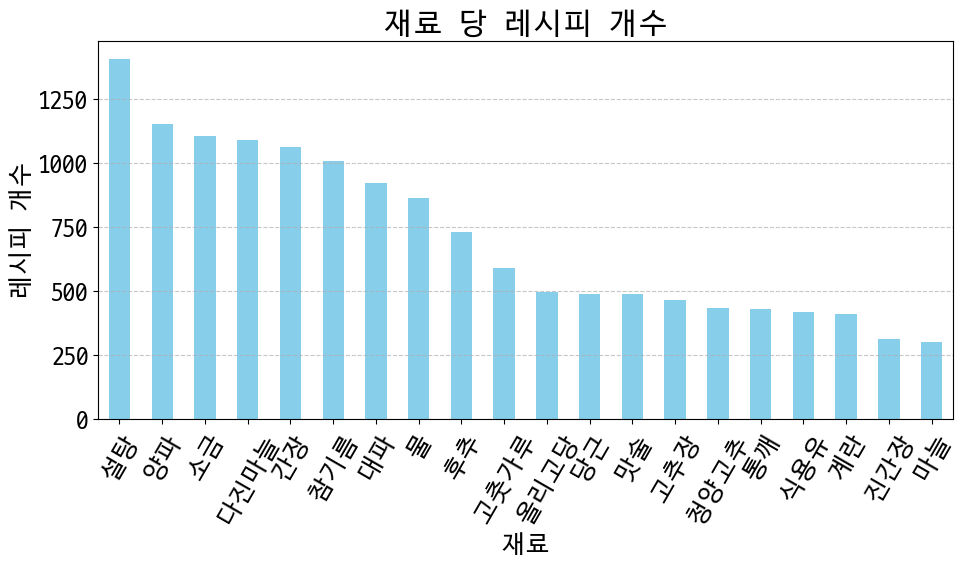

In [3]:
ingredient_counts = df['Ingredient'].value_counts().head(20)

plt.figure(figsize=(10,6))
ingredient_counts.plot(kind='bar', color='skyblue')
plt.title('재료 당 레시피 개수')
plt.xlabel('재료')
plt.ylabel('레시피 개수')
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

그래프에 따르면, 설탕을 사용하는 요리가 가장 많고, 그 다음으로 양파, 소금, 다진마늘 순으로 가장 많은 것을 확인하였다.
이 그래프를 참고하여 요리 재료를 구매할 수 있을 것 같다.

## 재료로 만들수 있는 음식 구하기
이제 원래 목표인 재료로 만들 수 있는 음식을 알아보기로 했다.
재료로 만들수 있는 음식이 많을 것이기 때문에, 그 중 20개만 구해보기로 했다.

In [4]:
search_keyword = '김치'

filtered_df = df[df['Ingredient'] == search_keyword]
food_df =filtered_df['Food'].value_counts()
top_food_df = food_df.head(20).index.tolist()

print(top_food_df)

['김치찌개', '김치비빔국수', '비지찌개', '김치찜', '두부김치', '김치볶음밥', '돼지고기김치찜', '부대찌개', '참치김치찌개', '청국장', '김치전', '비빔국수', '돼지고기김치찌개', '콩비지찌개', '삼겹살', '볶음밥', '잔치국수', '참치김밥', '녹두전', '청국장찌개']


## 가진 재료로 만들수 있는 최적의 음식 구하기
위에서는 재료 하나로 만들수 있는 모든 음식을 구했다.
하지만, 실제 냉장고에는 재료가 많기 때문에 그 재료로 만들수 있는 최적의 음식을 알아보려 한다.

여기서 최적의 음식의 조건은, 가진 재료를 사용해서 최대한 만들 수 있고, 내가 없는 재료가 가장 적은 것을 기준으로 하려 한다.

알고리즘을 고민해보자.
일단, 이 문제는 부분집합들의 교집합을 구하는 문제와 유사함.
하지만, 해당 문제의 시간복잡도는 가장 빠른게 $O(2^n)$.
이건 너무 느림. 따라서 다른 방법이 필요하다.

이 문제와 해당 문제의 차이점은 나는 딱히 정확한게 필요 없다.
내가 가진 재료들의 집합을 $A$, $n$번째 레시피를 $R_{n}$라 할때,
$$ X_{n} = A \cap R_{n} $$ 라고 하자.
$X_{n}$과 $R_{n}$의 유사도를 검사해서 높은 순으로 정렬한다.
이러면 완성일거 같은 느낌?

그대로 구현해봅시다.

In [84]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0.0 

A = {'토마토', '치즈', '햄', '고추장', '계란', '양파'}

R = df.groupby(["Food", "RecipeName"])['Ingredient'].apply(set).reset_index()

result = R.copy()
similarities = np.zeros(len(result))
for index, row in R.iterrows():
    Rn = row['Ingredient']
    Xn = A & Rn
    if len(Xn) == 0:
        continue
    sim = jaccard_similarity(Xn, Rn)
    similarities[index] = np.float64(sim)
result['Similarity'] = similarities

result = result.sort_values(by="Similarity", ascending=False).head(30)
result

,Food,RecipeName,Ingredient,Similarity
316,구운계란,가스 압력밥솥으로 맥반석 구운 계란 만들기,{계란},1.000000
320,구운계란,에어프라이어 구운계란만들기,{계란},1.000000
1848,샌드위치,샌드위치 만들기,"{빵, 토마토, 양파, 햄, 각종야채, 계란 삶은것, 치즈}",0.571429
207,계란찜,탱글탱글 부드러운 계란찜,"{물, 계란}",0.500000
611,달걀찜,탱글탱글 부드러운 계란찜,"{물, 계란}",0.500000
2883,치즈계란말이,아이가 좋아하는 치즈계란말이~~,"{다진파, 소금, 계란, 치즈}",0.500000
2890,치즈계란말이,치즈듬뿍 치즈계란말이,"{대파, 허브솔트, 계란, 치즈}",0.500000
3111,토스트,아이간식:옛날토스트 추억의 샌드위치,"{식빵, 양배추, 양파, 햄, 당근, 달걀, 치즈}",0.428571
3154,파인애플볶음밥,파인애플볶음밥,"{대파, 굴소스, 파인애플, 양파, 계란, 햄, 즉석밥}",0.428571
673,닭고기덮밥,쫄깃한 닭다리살로 오야꼬동(일본식 닭고기 덮밥) 만들기!,"{표고버섯, 밥, 양파, 계란, 닭다리살}",0.400000


이렇게 내가 가진 재료로 쵀대로 만들수 있는 요리를 구해보았다.
이제 레시피 이름을 인터넷에 검색하면 해당하는 레시피를 찾을수 있게 된다.